In [1]:
!pip install deepchem # Colab might need to reinstall scipy so 1) uncomment 2) run 3) restart kernel 4) comment out 5) run after from the runtime menu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 53.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [2]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! git clone 'https://github.com/PeterF1234/DFT-ML-excited-state-redox/' # if using Google Colab

Cloning into 'DFT-ML-excited-state-redox'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 43 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (43/43), 4.81 MiB | 8.72 MiB/s, done.


In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import tempfile
import matplotlib.pyplot as plt
from math import sqrt

In [5]:
import deepchem as dc # we use tensorflow models only so ignore pytorch warnings
import rdkit
from rdkit import Chem

# Run before every test for reproducibility
def seed_all(n):
    np.random.seed(n)
    tf.random.set_seed(n)
    tf.keras.utils.set_random_seed(n)

## Deep4Chem

### Set up the database for E<sub>00</sub>

In [6]:
db = pd.read_csv("/content/DFT-ML-excited-state-redox/DB for chromophore_Sci_Data_rev02.csv")
len(db.Solvent.unique())

1336

There are 1336 different solvent in the database. Now let's see how many of them have more than 500 data points.

In [7]:
db.groupby("Solvent", as_index=False).count().query("Chromophore > 500")

,Solvent,Tag,Chromophore,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
48,C1CCCCC1,788,788,658,724,374,611,325,24,11,109,259,788,788
51,C1CCOC1,1437,1437,1245,1335,455,992,668,60,39,305,562,1437,1437
70,CC#N,2004,2004,1781,1848,768,1480,893,58,88,414,720,2004,2004
325,CCCCCC,669,669,587,623,212,455,225,31,52,112,247,669,669
519,CCO,969,969,863,844,305,662,440,22,26,163,301,969,969
531,CCOC(C)=O,667,667,607,603,249,442,276,77,57,133,252,667,667
568,CN(C)C=O,703,703,622,649,227,470,274,34,22,165,291,703,703
612,CO,1290,1290,1183,1146,447,925,542,75,58,220,367,1290,1290
718,CS(C)=O,795,795,703,715,220,517,396,40,25,210,291,795,795
822,Cc1ccccc1,1580,1580,1349,1470,508,1129,574,60,28,323,764,1580,1580


Create the dataset object for DeepChem from the acetonitrile E<sub>00</sub> database:

In [8]:
ACN_data_ = db.get(["Chromophore", "Solvent", "Absorption max (nm)", "Emission max (nm)", "Lifetime (ns)"]).query("Solvent == 'CC#N'").copy()
ACN_data_["E_00"] = ((1240. / ACN_data_["Absorption max (nm)"]) + (1240. / ACN_data_["Emission max (nm)"])) / 2
ACN_data = ACN_data_.dropna(subset=["E_00"]).get(["Chromophore","E_00"]).reset_index(drop=True).copy()

In [9]:
with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
  ACN_data.to_csv(tmpfile.name)
  loader = dc.data.CSVLoader(["E_00"], feature_field="Chromophore",
                             featurizer=dc.feat.CircularFingerprint())
  ACN_dataset = loader.create_dataset(tmpfile.name)

len(ACN_dataset)

1693

Create the dataset object for DeepChem from the dichloromethane E<sub>00</sub> database:

In [10]:
DCM_data_ = db.get(["Chromophore", "Solvent", "Absorption max (nm)", "Emission max (nm)", "Lifetime (ns)"]).query("Solvent == 'ClCCl'").copy()
DCM_data_["E_00"] = ((1240. / DCM_data_["Absorption max (nm)"]) + (1240. / DCM_data_["Emission max (nm)"])) / 2
DCM_data = DCM_data_.dropna(subset=["E_00"]).get(["Chromophore","E_00"]).reset_index(drop=True).copy()

In [11]:
with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
  DCM_data.to_csv(tmpfile.name)
  loader = dc.data.CSVLoader(["E_00"], feature_field="Chromophore",
                             featurizer=dc.feat.CircularFingerprint())
  DCM_dataset = loader.create_dataset(tmpfile.name)

len(DCM_dataset)

2320

Create the dataset object for DeepChem from the dimethylformamide E<sub>00</sub> database:

In [12]:
DMF_data_ = db.get(["Chromophore", "Solvent", "Absorption max (nm)", "Emission max (nm)", "Lifetime (ns)"]).query("Solvent == 'CN(C)C=O'").copy()
DMF_data_["E_00"] = ((1240. / DMF_data_["Absorption max (nm)"]) + (1240. / DMF_data_["Emission max (nm)"])) / 2
DMF_data = DMF_data_.dropna(subset=["E_00"]).get(["Chromophore","E_00"]).reset_index(drop=True).copy()

In [13]:
with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
  DMF_data.to_csv(tmpfile.name)
  loader = dc.data.CSVLoader(["E_00"], feature_field="Chromophore",
                             featurizer=dc.feat.CircularFingerprint())
  DMF_dataset = loader.create_dataset(tmpfile.name)

len(DMF_dataset)

591

Preapre the data via min-max normalization and train-test split:

In [14]:
ACN_transformer = dc.trans.MinMaxTransformer(transform_y=True, dataset=ACN_dataset)
ACN_dataset_normed = ACN_transformer.transform(ACN_dataset)

DCM_transformer = dc.trans.MinMaxTransformer(transform_y=True, dataset=DCM_dataset)
DCM_dataset_normed = DCM_transformer.transform(DCM_dataset)

DMF_transformer = dc.trans.MinMaxTransformer(transform_y=True, dataset=DMF_dataset)
DMF_dataset_normed = DMF_transformer.transform(DMF_dataset)

splitter = dc.splits.RandomSplitter()
ACN_train, ACN_test = splitter.train_test_split(ACN_dataset_normed, frac_train=0.8, seed=11)
DCM_train, DCM_test = splitter.train_test_split(DCM_dataset_normed, frac_train=0.8, seed=11)
DMF_train, DMF_test = splitter.train_test_split(DMF_dataset_normed, frac_train=0.8, seed=11)

### Build models

In [15]:
def acc_plot(pred_model, test_set, transformer, savefig_name=""):
  preds = pred_model.predict(test_set) # we can also use model.predict(test_dataset, transformers=[transformer])

  sns.reset_orig()
  sns.set_style("ticks")
  scale=1.6
  sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                                scale,'xtick.major.width': scale,'ytick.major.width': scale})
  
  sns.scatterplot(x=transformer.untransform(test_set.y).reshape(-1), y=transformer.untransform(preds).reshape(-1)) # y is a 2D array, we need to flatten it
  plt.plot(np.linspace(1, 5, 50), np.linspace(1, 5, 50), color='grey', ls='--')
  plt.xlabel("$E_{00,actual}$ [eV]")
  plt.ylabel("$E_{00,predicted}$ [eV]")
  plt.xlim(1.4,4.2)
  plt.ylim(1.4,4.2)
  if savefig_name == "":
    plt.show()
  else:
    plt.savefig(savefig_name)
  plt.close()

def acc_plot_b(pred_model, test_set_a, test_set_b, transformer, savefig_name=""):
  preds_a = pred_model.predict(test_set_a)
  preds_b = pred_model.predict(test_set_b)

  sns.reset_orig()
  sns.set_style("ticks")
  scale=1.6
  sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                                scale,'xtick.major.width': scale,'ytick.major.width': scale})
  
  # thistle, lightsteelblue, lightblue; deeppink
  kwargs_a = {"s": 50, "color":"lightsteelblue", "alpha":0.75}
  kwargs_b = {"s": 100, "color":"deeppink", "alpha":1.} #, 'edgecolor':"black"}
  g = sns.scatterplot(x=transformer.untransform(test_set_a.y).reshape(-1), y=transformer.untransform(preds_a).reshape(-1), **kwargs_a)
  h = sns.scatterplot(x=transformer.untransform(test_set_b.y).reshape(-1), y=transformer.untransform(preds_b).reshape(-1), **kwargs_b)
  plt.plot(np.linspace(1, 5, 50), np.linspace(1, 5, 50), color='grey', ls='--')
  plt.xlabel("$E_{00,actual}$ [eV]")
  plt.ylabel("$E_{00,predicted}$ [eV]")
  plt.xlim(1.4,4.2)
  plt.ylim(1.4,4.2)
  if savefig_name == "":
    plt.show()
  else:
    plt.savefig(savefig_name, dpi=200, bbox_inches='tight', pad_inches=0.05)
  plt.close()

def model_builder(neurons, LR):
  keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1)
  ])

  optimizer = dc.models.optimizers.Adam(learning_rate=LR)
  return dc.models.KerasModel(keras_model, loss=dc.models.losses.L2Loss(), optimizer=optimizer)

In [16]:
NNEURONS = 100
EPOCHS = 20
LR = 0.001

In [17]:
seed_all(123)
ACN_model = model_builder(NNEURONS, LR)
ACN_model.fit(ACN_train, nb_epoch=EPOCHS)

metric_1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric_2 = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric_3 = dc.metrics.Metric(dc.metrics.mean_absolute_error)
print('training set score:', ACN_model.evaluate(ACN_train, [metric_1, metric_2, metric_3], transformers=[ACN_transformer]))
print('test set score:', ACN_model.evaluate(ACN_test, [metric_1, metric_2, metric_3], transformers=[ACN_transformer]))

training set score: {'pearson_r2_score': 0.9402359843497761, 'mean_squared_error': 0.016105211637703676, 'mean_absolute_error': 0.09366754918344977}
test set score: {'pearson_r2_score': 0.73233472180941, 'mean_squared_error': 0.06832185054630162, 'mean_absolute_error': 0.18802049313114816}


In [18]:
seed_all(123)
DCM_model = model_builder(NNEURONS, LR)
DCM_model.fit(DCM_train, nb_epoch=EPOCHS)

metric_1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric_2 = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric_3 = dc.metrics.Metric(dc.metrics.mean_absolute_error)
print('training set score:', DCM_model.evaluate(DCM_train, [metric_1, metric_2, metric_3], transformers=[DCM_transformer]))
print('test set score:', DCM_model.evaluate(DCM_test, [metric_1, metric_2, metric_3], transformers=[DCM_transformer]))

training set score: {'pearson_r2_score': 0.9519016609781501, 'mean_squared_error': 0.013670173004133767, 'mean_absolute_error': 0.0866067193520108}
test set score: {'pearson_r2_score': 0.7759180157376354, 'mean_squared_error': 0.06077802949200875, 'mean_absolute_error': 0.18264648229163533}


In [19]:
seed_all(123)
DMF_model = model_builder(NNEURONS, LR)
DMF_model.fit(DMF_train, nb_epoch=EPOCHS)

metric_1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric_2 = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric_3 = dc.metrics.Metric(dc.metrics.mean_absolute_error)
print('training set score:', DMF_model.evaluate(DMF_train, [metric_1, metric_2, metric_3], transformers=[DMF_transformer]))
print('test set score:', DMF_model.evaluate(DMF_test, [metric_1, metric_2, metric_3], transformers=[DMF_transformer]))

training set score: {'pearson_r2_score': 0.9299949427900417, 'mean_squared_error': 0.016844223163803358, 'mean_absolute_error': 0.10055527615927214}
test set score: {'pearson_r2_score': 0.6300420110877449, 'mean_squared_error': 0.09748330052237135, 'mean_absolute_error': 0.23429891700331865}


### Test the models on our molecules and save the predicted data into a file

Now we build the database from the SMILES that we actually want to predict E<sub>00</sub> for.

In [20]:
redox_db = pd.read_excel("/content/DFT-ML-excited-state-redox/ML_data/SMILES_with_ExptRedox.xlsx")
redox_smiles = redox_db.get(["SMILES", "redox_solvent", "E00"]).dropna()

In [21]:
redox_ACN = redox_smiles.query("redox_solvent in ['acetonitrile', 'benzonitrile']")
redox_DCM = redox_smiles.query("redox_solvent == 'dichloromethane'")
redox_DMF = redox_smiles.query("redox_solvent in ['DMFA', 'DMAC']")
# redox_DMF = redox_smiles.query("redox_solvent in ['DMFA', 'DMAC']").drop(index=[23,25]) # remove outliers

In [22]:
# featurize the chromophores

with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
  redox_ACN.to_csv(tmpfile.name)
  loader = dc.data.CSVLoader(["E00"], feature_field="SMILES",
                             featurizer=dc.feat.CircularFingerprint())
  redox_ACN_dataset = loader.create_dataset(tmpfile.name)

with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
  redox_DCM.to_csv(tmpfile.name)
  loader = dc.data.CSVLoader(["E00"], feature_field="SMILES",
                             featurizer=dc.feat.CircularFingerprint())
  redox_DCM_dataset = loader.create_dataset(tmpfile.name)

with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
  redox_DMF.to_csv(tmpfile.name)
  loader = dc.data.CSVLoader(["E00"], feature_field="SMILES",
                             featurizer=dc.feat.CircularFingerprint())
  redox_DMF_dataset = loader.create_dataset(tmpfile.name)

redox_ACN_normed = ACN_transformer.transform(redox_ACN_dataset)
redox_DCM_normed = DCM_transformer.transform(redox_DCM_dataset)
redox_DMF_normed = DMF_transformer.transform(redox_DMF_dataset)

In [23]:
print("Results for the ACETONITRILE dataset:")
print('test set score:', ACN_model.evaluate(ACN_test, [metric_1, metric_2, metric_3], transformers=[ACN_transformer]))
print('redox set score:', ACN_model.evaluate(redox_ACN_normed, [metric_1, metric_2, metric_3], transformers=[ACN_transformer]))
print("")
print("Results for the DICHLOROMETHANE dataset:")
print('test set score:', DCM_model.evaluate(DCM_test, [metric_1, metric_2, metric_3], transformers=[DCM_transformer]))
print('redox set score:', DCM_model.evaluate(redox_DCM_normed, [metric_1, metric_2, metric_3], transformers=[DCM_transformer]))
print("")
print("Results for the DIMETHYLFORMAMIDE dataset:")
print('test set score:', DMF_model.evaluate(DMF_test, [metric_1, metric_2, metric_3], transformers=[DMF_transformer]))
print('redox set score:', DMF_model.evaluate(redox_DMF_normed, [metric_1, metric_2, metric_3], transformers=[DMF_transformer]))

Results for the ACETONITRILE dataset:
test set score: {'pearson_r2_score': 0.73233472180941, 'mean_squared_error': 0.06832185054630162, 'mean_absolute_error': 0.18802049313114816}
redox set score: {'pearson_r2_score': 0.5449703939464196, 'mean_squared_error': 0.0775646247938739, 'mean_absolute_error': 0.2130709869108668}

Results for the DICHLOROMETHANE dataset:
test set score: {'pearson_r2_score': 0.7759180157376354, 'mean_squared_error': 0.06077802949200875, 'mean_absolute_error': 0.18264648229163533}
redox set score: {'pearson_r2_score': 0.007069307749829312, 'mean_squared_error': 0.05500574850907778, 'mean_absolute_error': 0.16062495663503742}

Results for the DIMETHYLFORMAMIDE dataset:
test set score: {'pearson_r2_score': 0.6300420110877449, 'mean_squared_error': 0.09748330052237135, 'mean_absolute_error': 0.23429891700331865}
redox set score: {'pearson_r2_score': 3.738142370322015e-05, 'mean_squared_error': 0.09845447929421525, 'mean_absolute_error': 0.23316859313635568}


In [24]:
ACN_preds = ACN_model.predict(redox_ACN_normed)
DCM_preds = DCM_model.predict(redox_DCM_normed)
DMF_preds = DMF_model.predict(redox_DMF_normed)

In [25]:
def get_scores(pred_model, data_set, transformer):
  R2_metric = dc.metrics.Metric(dc.metrics.r2_score)
  r_metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
  MAE_metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
  scores = pred_model.evaluate(data_set, [R2_metric, r_metric, MAE_metric], transformers=[transformer])
  R2 = round(scores['r2_score'], 2)
  r = round(sqrt(scores['pearson_r2_score']), 2)
  MAE = round(scores['mean_absolute_error'], 2)
  return R2, r, MAE

def acc_plot_c(pred_model, test_set_a, test_set_b, transformer, savefig_name=""):
  preds_a = pred_model.predict(test_set_a)
  preds_b = pred_model.predict(test_set_b)
  R2_a, r_a, MAE_a = get_scores(pred_model, test_set_a, transformer)
  score_string_a = f"test set\n$R^{2}$ = {R2_a}\nr = {r_a}\nMAE = {MAE_a} eV"
  R2_b, r_b, MAE_b = get_scores(pred_model, test_set_b, transformer)
  # score_string_b = f"OPC set\n$R^{2}$ = {R2_b}\nr = {r_b}\nMAE = {MAE_b} eV"
  score_string_b = f"OPC set\nMAE = {MAE_b} eV"

  sns.reset_orig()
  sns.set_style("ticks")
  scale=1.6
  sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                                scale,'xtick.major.width': scale,'ytick.major.width': scale})
  
  # thistle, lightsteelblue, lightblue; deeppink
  kwargs_a = {"s": 50, "color":"lightsteelblue", "alpha":0.75}
  kwargs_b = {"s": 100, "color":"deeppink", "alpha":1.} #, 'edgecolor':"black"}
  g = sns.scatterplot(x=transformer.untransform(test_set_a.y).reshape(-1), y=transformer.untransform(preds_a).reshape(-1), **kwargs_a)
  h = sns.scatterplot(x=transformer.untransform(test_set_b.y).reshape(-1), y=transformer.untransform(preds_b).reshape(-1), **kwargs_b)

  # props = dict(boxstyle='round', facecolor='wheat', edgecolor='grey', alpha=0.5)
  props = dict(boxstyle='round', facecolor=kwargs_a["color"], edgecolor='white', alpha=0.5)
  g.text(0.025, 0.97, score_string_a, transform=g.transAxes, fontsize=11,
         verticalalignment='top', bbox=props, c="k", linespacing=1.35)
  props = dict(boxstyle='round', facecolor=kwargs_b["color"], edgecolor='white', alpha=0.5)
  h.text(0.28, 0.97, score_string_b, transform=g.transAxes, fontsize=11,
         verticalalignment='top', bbox=props, c="k", linespacing=1.35)

  plt.plot(np.linspace(1, 5, 50), np.linspace(1, 5, 50), color='grey', ls='--')
  plt.xlabel("$E_{00,actual}$ [eV]")
  plt.ylabel("$E_{00,predicted}$ [eV]")
  plt.xlim(1.4,4.2)
  plt.ylim(1.4,4.2)
  if savefig_name == "":
    plt.show()
  else:
    plt.savefig(savefig_name, dpi=200, bbox_inches='tight', pad_inches=0.05)
  plt.close()


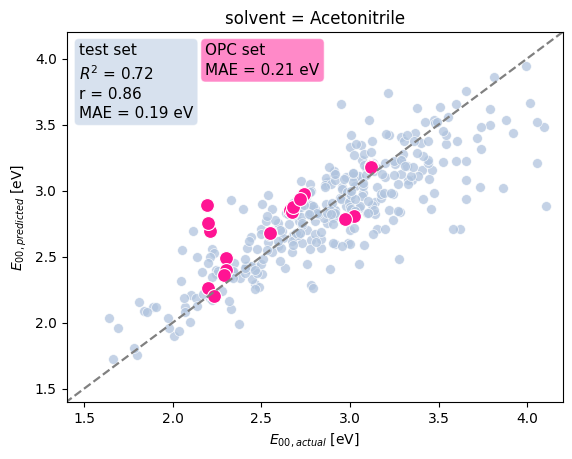

In [26]:
# run this cell again if the image format is different from the plots below
plt.title("solvent = Acetonitrile")
acc_plot_c(ACN_model, ACN_test, redox_ACN_normed, ACN_transformer)

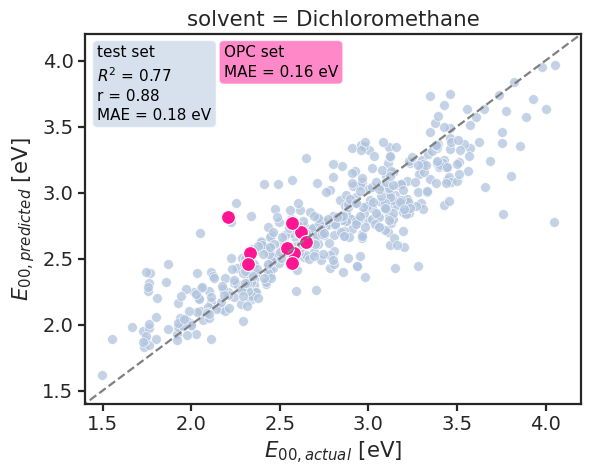

In [27]:
# run this cell again if the image format is different from the plots below
plt.title("solvent = Dichloromethane")
acc_plot_c(DCM_model, DCM_test, redox_DCM_normed, DCM_transformer)

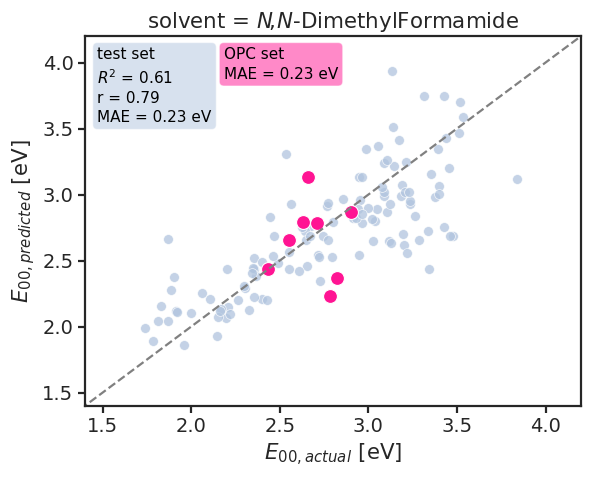

In [28]:
plt.title(r"solvent = $\it{N\!,\!N}$-DimethylFormamide")
acc_plot_c(DMF_model, DMF_test, redox_DMF_normed, DMF_transformer)

uncomment the code below to generate images of the plots above

In [35]:
plt.title("solvent = Acetonitrile")
acc_plot_c(ACN_model, ACN_test, redox_ACN_normed, ACN_transformer, savefig_name="ML_ACN.png")
plt.title("solvent = Dichloromethane")
acc_plot_c(DCM_model, DCM_test, redox_DCM_normed, DCM_transformer, savefig_name="ML_DCM.png")
plt.title(r"solvent = $\it{N\!,\!N}$-DimethylFormamide")
acc_plot_c(DMF_model, DMF_test, redox_DMF_normed, DMF_transformer, savefig_name="ML_DMF.png")

Check the individual values of the predictions:

In [30]:
ACN_e00preds = redox_db.query("redox_solvent in ['acetonitrile', 'benzonitrile']").get(["molecule","E00"]).copy()
ACN_e00preds["ML_true"] = ACN_transformer.untransform(redox_ACN_normed.y).reshape(-1)
ACN_e00preds["ML_pred"] = ACN_transformer.untransform(ACN_preds).reshape(-1)
ACN_e00preds

,molecule,E00,ML_true,ML_pred
0,PA_1,2.66,2.66,2.851689
1,PA_2,2.74,2.74,2.975755
8,Rh_6G,2.20,2.20,2.261771
9,Rh_B,2.23,2.23,2.200083
10,Eos_Y,2.30,2.30,2.489458
11,Eos_1,2.21,2.21,2.693586
12,Eos_2,2.19,2.19,2.889429
13,Eos_3,2.20,2.20,2.757211
14,Mes-Acr_1,2.55,2.55,2.676358
15,Ph-Acr_1,2.30,2.30,2.398415


In [31]:
DCM_e00preds = redox_db.query("redox_solvent == 'dichloromethane'").get(["molecule","E00"]).copy()
DCM_e00preds["ML_true"] = DCM_transformer.untransform(redox_DCM_normed.y).reshape(-1)
DCM_e00preds["ML_pred"] = DCM_transformer.untransform(DCM_preds).reshape(-1)
DCM_e00preds

,molecule,E00,ML_true,ML_pred
5,PDI_1,2.332547,2.332547,2.543094
6,PDI_2,2.320666,2.320666,2.461079
7,PDI_3,2.207838,2.207838,2.815690
17,BOH-Acr_o,2.620000,2.620000,2.704430
18,BOH-Acr_m,2.580000,2.580000,2.544422
19,BOH-Acr_p,2.570000,2.570000,2.770537
20,BF3-Acr_o,2.650000,2.650000,2.626451
21,BF3-Acr_m,2.570000,2.570000,2.465673
22,BF3-Acr_p,2.540000,2.540000,2.578391


In [32]:
DMF_e00preds = redox_db.query("redox_solvent in ['DMFA', 'DMAC']").get(["molecule","E00"]).copy()
DMF_e00preds["ML_true"] = DMF_transformer.untransform(redox_DMF_normed.y).reshape(-1)
DMF_e00preds["ML_pred"] = DMF_transformer.untransform(DMF_preds).reshape(-1)
DMF_e00preds

,molecule,E00,ML_true,ML_pred
3,Me2-Acr_2,2.550,2.550,2.658220
4,Me2-Acr_3,2.710,2.710,2.784899
23,PTZ_1,2.785,2.785,2.227469
24,PTZ_2,2.433,2.433,2.435502
25,PTZ_3,2.822,2.822,2.365856
33,POZ_1,2.660,2.660,3.134652
34,POZ_2,2.900,2.900,2.866703
36,POZ_4,2.630,2.630,2.788104


uncomment the code below to obtain the predictions in a csv file

In [33]:
# ML_preds = pd.concat([ACN_e00preds,DCM_e00preds,DMF_e00preds]).sort_index(ascending=True)
# ML_preds.to_csv("ML_preds_3_solvent_separate_models.csv")

## Calculate similarities between SMILES in the Deep4Chem and redox databases

### Local calculations

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS

In [ ]:
redox_smilesonly = redox_ACN["SMILES"].to_list()
ACN_data_smilesonly = ACN_data["Chromophore"].to_list()

In [ ]:
def get_best_MCS(target_SMILES, query_SMILES_list):
  maxmols = 0
  beststring = ""
  bestID = 0
  for N, i in enumerate(query_SMILES_list):
    mols = [Chem.MolFromSmiles(target_SMILES), Chem.MolFromSmiles(i)]
    matches = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True, matchValences=True, completeRingsOnly=True)
    if matches.numAtoms > maxmols:
      bestID = N
      beststring = matches.smartsString
      maxmols = matches.numAtoms
  return bestID, beststring, maxmols

def get_best_MCS_list(target_SMILES, query_SMILES_list):
  maxmols = []
  beststrings = []
  for i in query_SMILES_list:
    mols = [Chem.MolFromSmiles(target_SMILES), Chem.MolFromSmiles(i)]
    matches = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True, matchValences=True, completeRingsOnly=True)
    beststrings.append(matches.smartsString)
    maxmols.append(matches.numAtoms)
  return maxmols, beststrings

def get_best_MCS_dataframe(target_SMILES_list, query_SMILES_list):
  df = pd.DataFrame()
  for q in query_SMILES_list:
    for t in target_SMILES_list:
      mols = [Chem.MolFromSmiles(t), Chem.MolFromSmiles(q)]
      matches = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True, matchValences=True, completeRingsOnly=True)
      sub_df = pd.DataFrame({"OPC_molecule": [t], "database_molecule": [q], "maxmol": [matches.numAtoms], "match_sting": [matches.smartsString]})
      df = pd.concat([df, sub_df], ignore_index=True)
  return df

def get_similarities(target_mol, others):
  refmol_ = Chem.MolFromSmiles(target_mol)
  refmol = Chem.RDKFingerprint(refmol_)
  sims = []
  for i in others:
    i_ = Chem.MolFromSmiles(i)
    i_ = Chem.RDKFingerprint(i_)
    sims.append(rdkit.DataStructs.FingerprintSimilarity(refmol,i_))
  return sims

In [ ]:
%%time
target_index = 0
mols, strings = get_best_MCS_list(redox_smilesonly[target_index], ACN_data_smilesonly)

CPU times: user 1min 21s, sys: 84.9 ms, total: 1min 21s
Wall time: 1min 24s


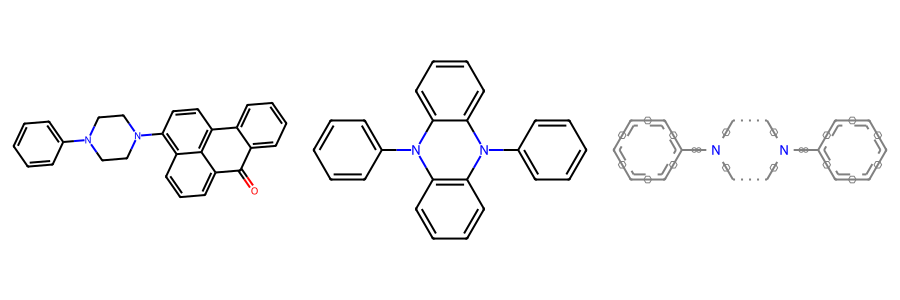

In [ ]:
best_index = mols.index(max(mols))
mol_1 = Chem.MolFromSmiles(ACN_data_smilesonly[best_index])
mol_2 = Chem.MolFromSmiles(redox_smilesonly[target_index])
commonmol = Chem.MolFromSmarts(strings[best_index])
Draw.MolsToImage([mol_1, mol_2, commonmol],subImgSize=(300,300), legends=None)

the code below can take long to complete

In [ ]:
# %%time
# matches_df = get_best_MCS_dataframe(redox_smilesonly, ACN_data_smilesonly[:111])
# matches_df.to_csv("most_common_substructures_in_ACN.csv")

In [ ]:
# best_index = mols.index(max(mols))
# mol_1 = Chem.MolFromSmiles(ACN_data_smilesonly[best_index])
# mol_2 = Chem.MolFromSmiles(redox_smilesonly[target_index])
# commonmol = Chem.MolFromSmarts(strings[best_index])
# Draw.MolsToImage([mol_1, mol_2, commonmol],subImgSize=(300,300), legends=None)

In [ ]:
# %%time
# ACN_sims = [get_similarities(i, ACN_data_smilesonly) for i in redox_smilesonly]

In [ ]:
# len(ACN_sims)

In [ ]:
# sns.reset_orig()
# plt.style.use("seaborn-paper")
# scale=1.5
# sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
#                                                scale,'xtick.major.width': scale,'ytick.major.width': scale})

# fsize = (16,7)
# fig, axs = plt.subplots(nrows=3, ncols=6, figsize=fsize, sharey=True, sharex=True)

# for i, ax in enumerate(fig.axes):
#   sns.histplot(ACN_sims[i], ax=ax)

# sns.despine()
# plt.tight_layout()
# plt.show()
# plt.close()
# # plt.savefig('similarities.png', dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
# target_index = 5
# best_match_index = ACN_sims[target_index].index(max(ACN_sims[target_index]))

# print(f"target OPC: {ACN_data_smilesonly[best_match_index]}")
# print(f"best match: {redox_smilesonly[target_index]}")

# mol_1 = Chem.MolFromSmiles(ACN_data_smilesonly[best_match_index])
# mol_2 = Chem.MolFromSmiles(redox_smilesonly[target_index])
# Draw.MolsToImage([mol_1, mol_2],subImgSize=(300,300), legends=None)

### Process similarity databases

In [ ]:
def plot_similarity_hist(df, savefig_name=""):
  sns.reset_orig()
  plt.style.use("seaborn-paper")
  scale=1.5
  sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                                scale,'xtick.major.width': scale,'ytick.major.width': scale})

  g = sns.FacetGrid(df.rename(columns={"OPC_code": "OPC", "fingerprint_similarity": "Tanimoto coefficient"}), col="OPC", col_wrap=5) #, height=5, aspect=0.75)
  g.map_dataframe(sns.histplot, x="Tanimoto coefficient")
  # g.set(xlabel=r'MAE [V]', ylabel=None)
  # g.add_legend(frameon=True, title=None, loc='center', facecolor="beige", framealpha=1, ncol=1, handletextpad=0.3, bbox_to_anchor=(0.901, 0.285), fontsize=15)

  for ax in g.axes.flat:
    ax.grid(True, axis='y', zorder=0)
    ax.set_axisbelow(True)

  sns.despine()
  plt.xlim(0,1)
  plt.tight_layout()
  # plt.show()
  if savefig_name != "":
    plt.savefig(savefig_name, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.close()
  else:
    plt.show()
    plt.close()

The databases below were generated using a modified version of the `get_best_MCS_list()` function with a separate script on a high-performance workstation.

In [ ]:
ACN_MCS = pd.read_csv("/content/DFT-ML-excited-state-redox/ML_data/most_common_substructures_in_ACN.csv.gz", index_col=0, compression='gzip')
DCM_MCS = pd.read_csv("/content/DFT-ML-excited-state-redox/ML_data/most_common_substructures_in_DCM.csv.gz", index_col=0, compression='gzip')
DMF_MCS = pd.read_csv("/content/DFT-ML-excited-state-redox/ML_data/most_common_substructures_in_DMF.csv.gz", index_col=0, compression='gzip')

In [ ]:
OPC_names = redox_db.molecule
OPC_smiles = redox_db.SMILES
OPC_translator = dict(zip(OPC_smiles, OPC_names))

ACN_MCS["OPC_code"] = ACN_MCS["OPC_molecule"]
ACN_MCS.replace({"OPC_code": OPC_translator}, inplace=True)
DCM_MCS["OPC_code"] = DCM_MCS["OPC_molecule"]
DCM_MCS.replace({"OPC_code": OPC_translator}, inplace=True)
DMF_MCS["OPC_code"] = DMF_MCS["OPC_molecule"]
DMF_MCS.replace({"OPC_code": OPC_translator}, inplace=True)

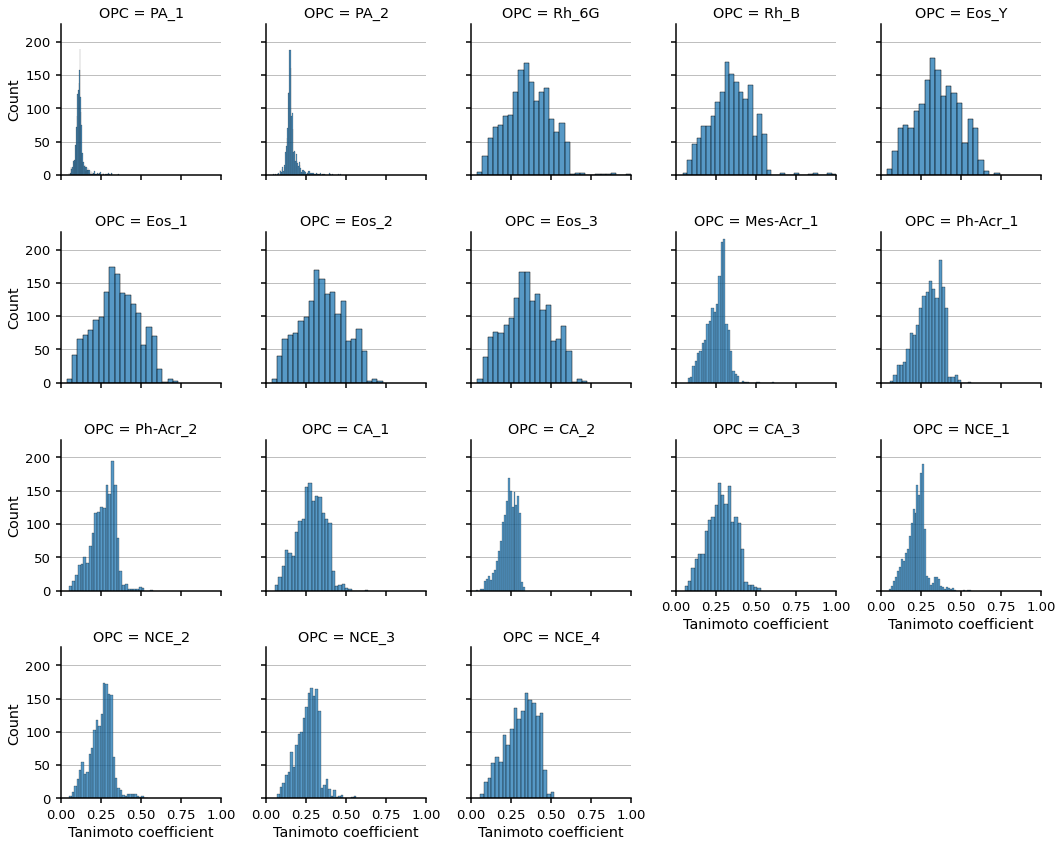

In [ ]:
plot_similarity_hist(ACN_MCS)

uncomment the code below to obtain the histograms as png images

In [ ]:
# plot_similarity_hist(ACN_MCS, savefig_name="ACN_similarities.png")
# plot_similarity_hist(DCM_MCS, savefig_name="DCM_similarities.png")
# plot_similarity_hist(DMF_MCS, savefig_name="DMF_similarities.png")

In [ ]:
ACN_MCS.get(["OPC_code","MCS_maxmol","fingerprint_similarity"]).groupby("OPC_code", as_index=False).max()

,OPC_code,MCS_maxmol,fingerprint_similarity
0,CA_1,34,0.638520
1,CA_2,21,0.338235
2,CA_3,21,0.527753
3,Eos_1,23,0.732620
4,Eos_2,23,0.728713
5,Eos_3,23,0.726253
6,Eos_Y,23,0.740494
7,Mes-Acr_1,15,0.612374
8,NCE_1,19,0.562162
9,NCE_2,19,0.546227


In [ ]:
ACN_MCS.query("OPC_code == 'CA_3' and MCS_maxmol == 21")

,OPC_molecule,database_molecule,fingerprint_similarity,MCS_maxmol,MCS_match_sting,OPC_code
17221,ClC1=C(N2C3=C(C=CC=C3)C4=C2C=CC=C4)C(C#N)=C(N5...,C[n+]1ccn(CCCCc2ccc3c(c2)c2ccccc2n3-c2cc(C#N)c...,0.512446,21,[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]2:&@[#6&R](:...,CA_3
29821,ClC1=C(N2C3=C(C=CC=C3)C4=C2C=CC=C4)C(C#N)=C(N5...,C[n+]1ccn(CCCCc2ccc3c(c2)c2ccccc2n3-c2cc(C#N)c...,0.527753,21,[#6&R]1:&@[#6&R](-&!@[#7&R]2:&@[#6&R]3:&@[#6&R...,CA_3


Use the code below to visualize the results of the similarity analysis:

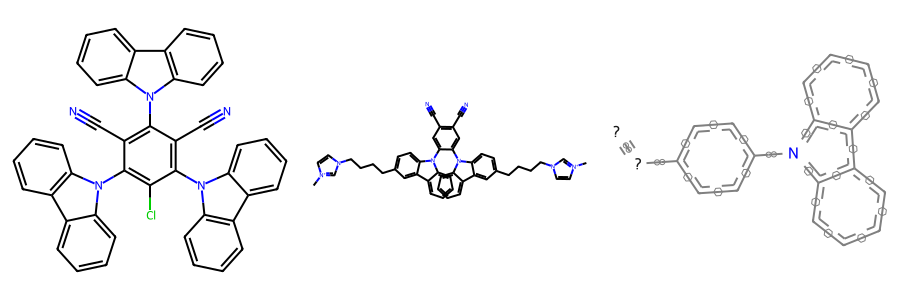

In [ ]:
qry = ACN_MCS.query("OPC_code == 'CA_3' and MCS_maxmol == 21")
mol_1 = Chem.MolFromSmiles(qry["OPC_molecule"].iloc[0])
mol_2 = Chem.MolFromSmiles(qry["database_molecule"].iloc[1]) # iloc[1] selects the 2nd row from above
commonmol = Chem.MolFromSmarts(qry["MCS_match_sting"].iloc[1])
Draw.MolsToImage([mol_1, mol_2, commonmol],subImgSize=(300,300), legends=None)

In [ ]:
ACN_MCS.query("OPC_code == 'CA_2' and fingerprint_similarity >= 0.3382")

,OPC_molecule,database_molecule,fingerprint_similarity,MCS_maxmol,MCS_match_sting,OPC_code
14628,FC1=C(N(C2=CC=CC=C2)C3=CC=CC=C3)C(C#N)=C(N(C4=...,Cc1cccc(C)c1Nc1ccc(/C=C/c2cccnc2)cc1,0.338235,15,[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:...,CA_2


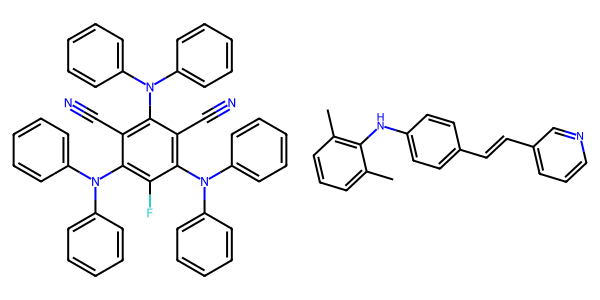

In [ ]:
qry = ACN_MCS.query("OPC_code == 'CA_2' and fingerprint_similarity >= 0.3382")
mol_1 = Chem.MolFromSmiles(qry["OPC_molecule"].iloc[0])
mol_2 = Chem.MolFromSmiles(qry["database_molecule"].iloc[0])
Draw.MolsToImage([mol_1, mol_2],subImgSize=(300,300), legends=None)

In [ ]:
qry["OPC_molecule"].iloc[0]

'FC1=C(N(C2=CC=CC=C2)C3=CC=CC=C3)C(C#N)=C(N(C4=CC=CC=C4)C5=CC=CC=C5)C(C#N)=C1N(C6=CC=CC=C6)C7=CC=CC=C7'

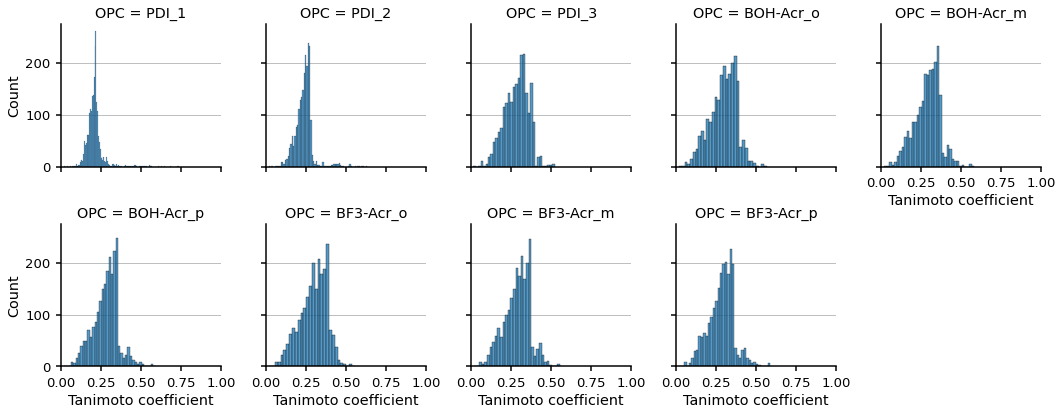

In [ ]:
plot_similarity_hist(DCM_MCS)

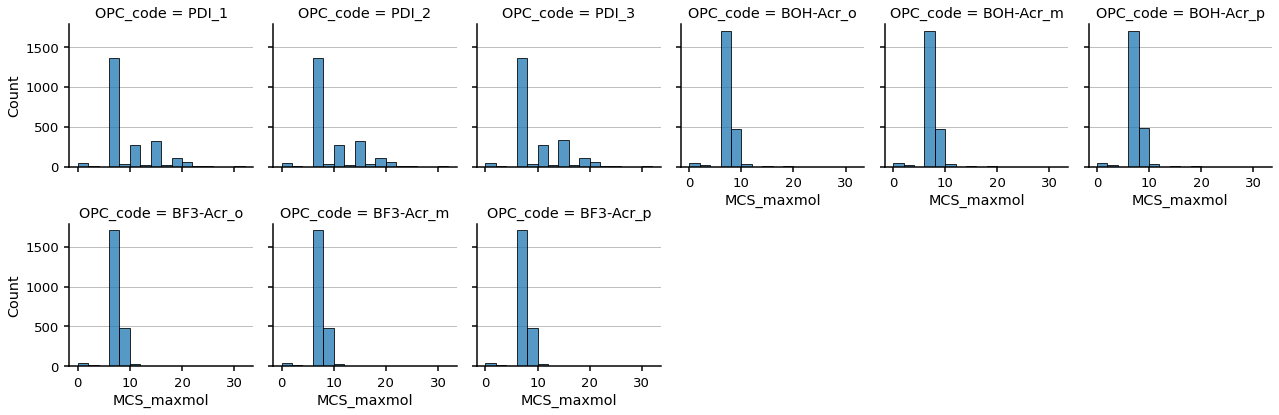

In [ ]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.FacetGrid(DCM_MCS, col="OPC_code", col_wrap=6) #, height=5, aspect=0.75)
g.map_dataframe(sns.histplot, x="MCS_maxmol", binwidth=2)
# g.set(xlabel=r'MAE [V]', ylabel=None)
# g.add_legend(frameon=True, title=None, loc='center', facecolor="beige", framealpha=1, ncol=1, handletextpad=0.3, bbox_to_anchor=(0.901, 0.285), fontsize=15)

for ax in g.axes.flat:
  ax.grid(True, axis='y')
  ax.set_axisbelow(True)

sns.despine()
# plt.xlim(0,1)
plt.tight_layout()
plt.show()
plt.close()
# plt.savefig('similarities.png', dpi=200, bbox_inches='tight', pad_inches=0)

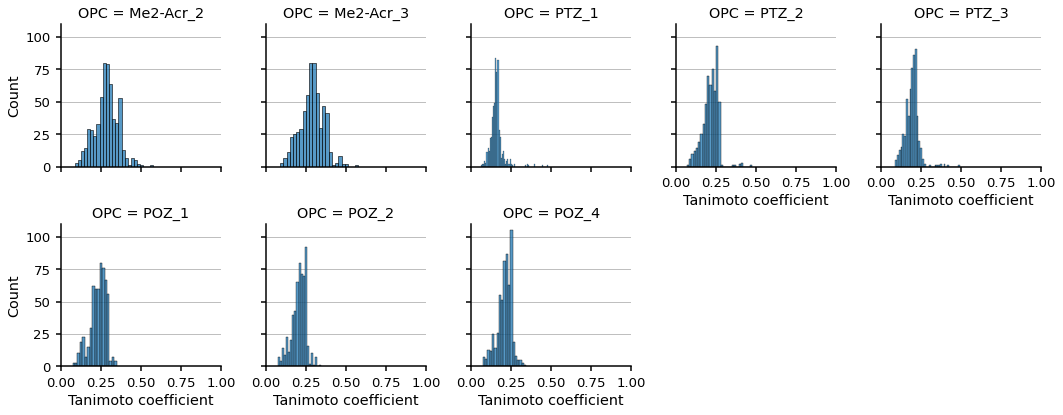

In [ ]:
plot_similarity_hist(DMF_MCS)

In [ ]:
DCM_MCS.get(["OPC_code","MCS_maxmol","fingerprint_similarity"]).groupby("OPC_code", as_index=False).max()

,OPC_code,MCS_maxmol,fingerprint_similarity
0,BF3-Acr_m,20,0.570204
1,BF3-Acr_o,20,0.553498
2,BF3-Acr_p,20,0.586860
3,BOH-Acr_m,20,0.580610
4,BOH-Acr_o,20,0.566038
5,BOH-Acr_p,20,0.592135
6,PDI_1,32,0.739635
7,PDI_2,32,0.630042
8,PDI_3,32,0.522946


In [ ]:
DMF_MCS.get(["OPC_code","MCS_maxmol","fingerprint_similarity"]).groupby("OPC_code", as_index=False).max()

,OPC_code,MCS_maxmol,fingerprint_similarity
0,Me2-Acr_2,22,0.574528
1,Me2-Acr_3,22,0.573970
2,POZ_1,18,0.349609
3,POZ_2,14,0.344043
4,POZ_4,18,0.344782
5,PTZ_1,20,0.481928
6,PTZ_2,15,0.474157
7,PTZ_3,20,0.490099
